In [25]:
%matplotlib widget
# %matplotlib inline

import numpy as np
import os
# import pandas as pd
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import datetime
import importlib
import math
import pandas as pd

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torchmetrics.functional import pairwise_cosine_similarity
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

from datasets.wrgbd import WRGBD
from datasets.utils import SquarePad

import clp.sk_clp
from clp.sk_clp import CLP

In [2]:

root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'
dataset_dir = '/home/ehajizad/datasets/rgbd-dataset'

test_size = 0.2
train_size = 1 - test_size
subsampling_factor = 10
depth_mask = False
obj_level = False
seed = np.random.randint(1000)


# Dataset transforms
transform=transforms.Compose([
    SquarePad(global_max_wh=160),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# load dataset
train_ds = WRGBD(root_dir = dataset_dir, transform=transform, depth_mask = depth_mask, 
                     train_test_split='custom', subset='train',
                     obj_level=obj_level, subsampling_factor=subsampling_factor, seed=seed)
test_ds = WRGBD(root_dir = dataset_dir, transform=transform, depth_mask = depth_mask, 
                    train_test_split='custom', subset='test', 
                    obj_level=obj_level, subsampling_factor=subsampling_factor, seed=seed)

All target lists are created
All target lists are created


In [3]:
n_classes = len(np.unique(train_ds.targets))

device = "cuda" if torch.cuda.is_available() else "cpu"

feat_ext = torchvision.models.vgg16(weights='IMAGENET1K_V1')
# model = nn.Sequential(*list(vgg16.children())[:2], nn.Flatten(), *list(vgg16.children())[2][:2] )
feat_ext = feat_ext.features
feat_ext = feat_ext.to(device)

In [4]:
## Extract training features
embeddings = []
labels = []

feat_ext_dl = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=8)

with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        image, label = image.to(device), label.to(device)
        emb = feat_ext(image).flatten(start_dim=1)
        embeddings.append(emb)
        labels.append(label)

embeddings = torch.cat(embeddings, 0)
# embeddings = np.array(torch.Tensor.cpu(embeddings))

labels = torch.cat(labels)
# labels = np.array(torch.Tensor.cpu(labels))

## Extract test features

test_embeddings = []
test_labels = []

feat_ext_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8)

with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        image, label = image.to(device), label.to(device)
        emb = feat_ext(image).flatten(start_dim=1)
        test_embeddings.append(emb)
        test_labels.append(label)

test_embeddings = torch.cat(test_embeddings, 0)
# test_embeddings = np.array(torch.Tensor.cpu(test_embeddings))

test_labels = torch.cat(test_labels)
test_labels = np.array(torch.Tensor.cpu(test_labels))

# X_train, X_test = embeddings.copy(), test_embeddings.copy()
# y_train, y_test = labels.copy(), test_labels.copy()

X_train, X_test = embeddings, test_embeddings
y_train, y_test = labels, test_labels

In [27]:
importlib.reload(clp.sk_clp)
from clp.sk_clp import CLP

clp_classifier = CLP(sim_metric='cosine',
                    n_protos=200,
                    num_classes=51,
                    alpha_init=0.633, 
                    sim_th_init=0.442, 
                    max_allowed_mistakes=6, 
                    k_hit=1.357,
                    k_miss=0.016,
                    tau_sim_th_pos=100, 
                    tau_sim_th_neg=126,
                    k_sim_th_pos=0.770,
                    k_sim_th_neg=1.1,
                    device=device, 
                    verbose=0)


In [28]:
clp_classifier.fit(X_train, y_train)

CLP(alpha_init=0.633, k_hit=1.357, k_miss=0.016, k_sim_th_neg=1.1,
    k_sim_th_pos=0.77, max_allowed_mistakes=6, n_protos=200, num_classes=51,
    sim_th_init=0.442, tau_sim_th_neg=126, verbose=0)

In [29]:
y_pred_test = clp_classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
print(acc)

0.6746987951807228


In [17]:
alloc_protos = clp_classifier.prototypes_.cpu()[(clp_classifier.proto_labels_<51).squeeze(),:]
n_alloc_protos = len(alloc_protos)
print(n_alloc_protos)

110


In [25]:
X_train = X_train.to(device)
X_test = X_test.to(device)

In [26]:
X_all = torch.cat((X_train, X_test), dim=0)

In [28]:
y_all = torch.cat((y_train,torch.from_numpy(y_test) ), dim=0)

In [35]:
X_all.shape, y_all.shape

(torch.Size([20792, 8192]), torch.Size([20792]))

In [5]:
from sklearn.model_selection import (
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
    KFold
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

rng = np.random.RandomState(1338)
cmap_data = plt.cm.prism
cmap_cv = plt.cm.prism
n_splits = 4

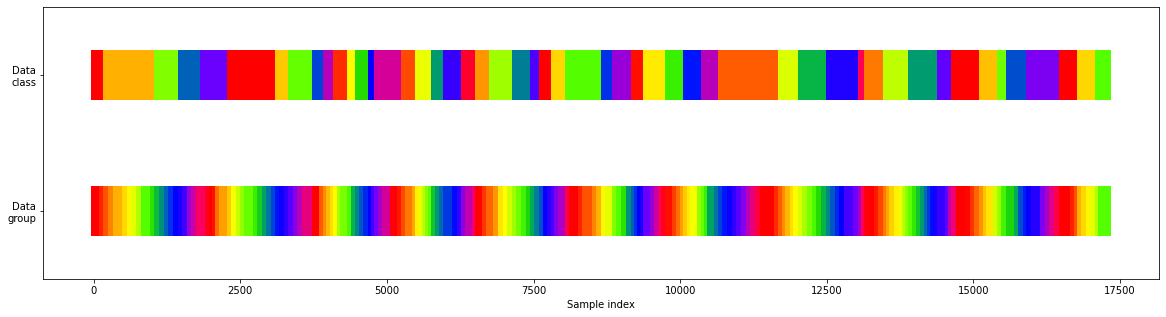

In [7]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(20,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

y = y_train.cpu()
groups = train_ds.obj_targets
    
visualize_groups(y, groups, "no groups")

In [ ]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

fig, ax = plt.subplots(figsize=(20,8))
cv = StratifiedGroupKFold(n_splits)
plot_cv_indices(cv, X_train, y, groups, ax, n_splits)

In [28]:
cv = GroupKFold(5)
splits=cv.split(X=X_train, y=y, groups=groups)

In [29]:
for ii, (tr, tt) in enumerate(splits):
    print((tr, tt))

(array([    0,     1,     2, ..., 17303, 17304, 17305]), array([  144,   145,   146, ..., 17185, 17186, 17187]))
(array([    0,     1,     2, ..., 17303, 17304, 17305]), array([   73,    74,    75, ..., 17125, 17126, 17127]))
(array([    0,     1,     2, ..., 17303, 17304, 17305]), array([  689,   690,   691, ..., 16966, 16967, 16968]))
(array([    0,     1,     2, ..., 17247, 17248, 17249]), array([ 1320,  1321,  1322, ..., 17303, 17304, 17305]))
(array([   73,    74,    75, ..., 17303, 17304, 17305]), array([    0,     1,     2, ..., 17247, 17248, 17249]))


In [106]:
for ii, (tr, tt) in enumerate(splits):
    clp_classifier = CLP(sim_metric='cosine',
                    n_protos=1000,
                    num_classes=51,
                    alpha_init=0.633, 
                    sim_th_init=0.442, 
                    max_allowed_mistakes=6, 
                    k_hit=1.357,
                    k_miss=0.016,
                    tau_sim_th_pos=100, 
                    tau_sim_th_neg=126,
                    k_sim_th_pos=0.770,
                    k_sim_th_neg=1.1,
                    device=device, 
                    verbose=0)
    clp_classifier.fit(X_train[tr,:], y_train[tr])
    y_pred_test = clp_classifier.predict(X_train[tt,:])
    acc = accuracy_score(y_pred_test, y_train[tt])
    print(acc)

0.6954279015240328
0.6760849909584087
0.5728506787330316
0.7394198763670946


In [6]:
# this library even performs well on weird ranges
# adjust this to better ranges for better results
param_grid = {'alpha_init': Continuous(0.4, 1),
              'sim_th_init': Continuous(0, 1),
              'max_allowed_mistakes': Integer(1,6),
              'k_hit': Continuous(0, 4),
              'k_miss': Continuous(0, 1),
              'tau_sim_th_pos': Integer(1, 200),
              'tau_sim_th_neg': Integer(1, 200),
              'k_sim_th_pos': Continuous(0.5, 1),
              'k_sim_th_neg': Continuous(0.7, 1.2),
             }

In [7]:
importlib.reload(clp.sk_clp)
from clp.sk_clp import CLP
from sklearn_genetic.schedules import ExponentialAdapter
from sklearn.model_selection import (
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
    KFold
)
# The base classifier to tune

device = 'cpu'

clf = CLP(sim_metric='cosine',
                    n_protos=200,
                    num_classes=51,
                    alpha_init=1,
                    sim_th_init=0.4, 
                    max_allowed_mistakes=5,                  
                    k_hit=1, 
                    k_miss=1, 
                    tau_sim_th_pos=100, 
                    tau_sim_th_neg=20,
                    k_sim_th_pos=1, 
                    k_sim_th_neg=1,
                    device=device, 
                    verbose=0)


# train_indices = list(range(0, y_train.shape[0]))
# test_indices = list(range(y_train.shape[0], y_all.shape[0]))
# cv = [(train_indices, test_indices)]

y = y_train.cpu()
groups = train_ds.obj_targets
cv = GroupKFold(5)
splits=cv.split(X=X_train, y=y, groups=groups)
cv_splits = []
for ii, (tr, tt) in enumerate(splits):
    cv_splits.append((tr, tt))

mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)

# The main class from sklearn-genetic-opt
evolved_estimator = GASearchCV(estimator=clf,
                              cv=cv_splits,
                              scoring='accuracy',
                              param_grid=param_grid,
                              n_jobs=5,
                              verbose=True,
                              keep_top_k=4,
                              population_size=20,
                              generations=20)

In [13]:

X_train = X_train.cpu()
X_test = X_test.cpu()
y_train = y_train.cpu()
# y_test = y_test.cpu()

In [9]:
 # Train and optimize the estimator
evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.355799	0.23526    	0.606545   	0.00190181 
1  	40    	0.528336	0.143336   	0.632671   	0.0752647  
2  	40    	0.585198	0.0340882  	0.631023   	0.510073   
3  	40    	0.611613	0.0111367  	0.628356   	0.592974   
4  	40    	0.625476	0.0078736  	0.643729   	0.611504   
5  	40    	0.627745	0.00959431 	0.643184   	0.611868   
6  	40    	0.632132	0.00653883 	0.643184   	0.61733    
7  	40    	0.638247	0.00583813 	0.651618   	0.623508   
8  	40    	0.643439	0.00864091 	0.656758   	0.6197     
9  	40    	0.646115	0.0054045  	0.656758   	0.637035   
10 	40    	0.644983	0.00705633 	0.656758   	0.623555   
11 	40    	0.64848 	0.00882088 	0.660957   	0.618594   
12 	40    	0.653056	0.00633773 	0.660957   	0.636399   
13 	40    	0.655326	0.00447492 	0.660957   	0.647038   
14 	40    	0.657182	0.00524928 	0.662641   	0.642495   
15 	40    	0.659151	0.004999   	0.662099   	0.638035   
16 	40    	0.662297	0.00344396 	0.667944   	0.65

GASearchCV(cv=[(array([    0,     1,     2, ..., 17303, 17304, 17305]),
                array([  144,   145,   146, ..., 17247, 17248, 17249])),
               (array([    0,     1,     2, ..., 17303, 17304, 17305]),
                array([  291,   292,   293, ..., 16635, 16636, 16637])),
               (array([    0,     1,     2, ..., 17247, 17248, 17249]),
                array([   73,    74,    75, ..., 17303, 17304, 17305])),
               (array([   73,    74,    75, ..., 17303, 17304, 17305]),
                array([    0,     1,     2, ..., 17185, 17186, 17187])),
               (array([    0,     1,     2...
                       'max_allowed_mistakes': <sklearn_genetic.space.space.Integer object at 0x7fcb58a2c790>,
                       'sim_th_init': <sklearn_genetic.space.space.Continuous object at 0x7fcb58a2c520>,
                       'tau_sim_th_neg': <sklearn_genetic.space.space.Integer object at 0x7fcb58a2c880>,
                       'tau_sim_th_pos': <sklearn_genetic.space.space.Integer object at 0x7fcb58a2c8e0>},
           population_size=20, return_train_score=True, scoring='accuracy')

In [10]:
print(evolved_estimator.best_params_)

{'alpha_init': 0.6162745653493937, 'sim_th_init': 0.3386169851228551, 'max_allowed_mistakes': 5, 'k_hit': 2.6917909128816913, 'k_miss': 0.1506327678419761, 'tau_sim_th_pos': 16, 'tau_sim_th_neg': 98, 'k_sim_th_pos': 0.9134230939401677, 'k_sim_th_neg': 0.9698742714193911}


In [19]:
top_clp = evolved_estimator.best_estimator_

In [20]:
top_clp.fit(X_train, y_train)

CLP(alpha_init=0.7480752236096402, k_hit=0.8367901591863047,
    k_miss=0.0360704444569816, k_sim_th_neg=1.0474984987958915,
    k_sim_th_pos=0.8643844493504615, max_allowed_mistakes=6, n_protos=200,
    num_classes=51, sim_th_init=0.30317869063871394, tau_sim_th_neg=64,
    tau_sim_th_pos=101, verbose=0)

In [21]:
y_predict_ga = top_clp.predict(X_test)
print(accuracy_score(y_test, y_predict_ga))

0.6646586345381527


In [64]:
cv_res = pd.DataFrame(evolved_estimator.cv_results_)

In [65]:
cv_res.columns

Index(['param_alpha_init', 'param_sim_th_init', 'param_max_allowed_mistakes',
       'param_k_hit', 'param_k_miss', 'param_tau_sim_th_pos',
       'param_tau_sim_th_neg', 'param_k_sim_th_pos', 'param_k_sim_th_neg',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score',
       'rank_train_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'params'],
      dtype='object')

In [67]:
cv_res.sort_values(by=['rank_test_score'])[['param_alpha_init', 'param_sim_th_init', 'param_max_allowed_mistakes',
                                           'param_k_hit', 'param_k_miss', 'param_tau_sim_th_pos',
                                           'param_tau_sim_th_neg', 'param_k_sim_th_pos', 'param_k_sim_th_neg',
                                            'mean_train_score','mean_test_score']].head(30)

,param_alpha_init,param_sim_th_init,param_max_allowed_mistakes,param_k_hit,param_k_miss,param_tau_sim_th_pos,param_tau_sim_th_neg,param_k_sim_th_pos,param_k_sim_th_neg,mean_train_score,mean_test_score
771,0.748075,0.303179,6,0.83679,0.036070,101,64,0.864384,1.047498,0.902763,0.670953
783,0.748075,0.303179,6,0.83679,0.036070,101,64,0.864384,1.047498,0.902763,0.670953
794,0.748075,0.303179,6,0.83679,0.036070,101,64,0.864384,0.921704,0.904351,0.668326
816,0.748075,0.303179,6,0.83679,0.074149,101,64,0.864384,1.061440,0.898673,0.667944
781,0.748075,0.303179,6,0.83679,0.074149,101,64,0.864384,1.061440,0.898673,0.667944
704,0.748075,0.303179,6,0.83679,0.074149,101,64,0.864384,1.061440,0.898673,0.667944
635,0.748075,0.303179,6,0.83679,0.074149,101,64,0.864384,1.061440,0.898673,0.667944
810,0.748075,0.303179,6,0.83679,0.074149,101,64,0.864384,1.061440,0.898673,0.667944
808,0.748075,0.303179,6,0.83679,0.074149,101,64,0.864384,1.061440,0.898673,0.667944
749,0.748075,0.303179,6,0.83679,0.074149,101,64,0.864384,1.061440,0.898673,0.667944


In [18]:
evolved_estimator.best_params_

{'alpha_init': 0.7480752236096402,
 'sim_th_init': 0.30317869063871394,
 'max_allowed_mistakes': 6,
 'k_hit': 0.8367901591863047,
 'k_miss': 0.0360704444569816,
 'tau_sim_th_pos': 101,
 'tau_sim_th_neg': 64,
 'k_sim_th_pos': 0.8643844493504615,
 'k_sim_th_neg': 1.0474984987958915}

In [ ]:
alpha_init=0.633, 
sim_th_init=0.442, 
max_allowed_mistakes=6, 
k_hit=1.357,
k_miss=0.016,
tau_sim_th_pos=100, 
tau_sim_th_neg=126,
k_sim_th_pos=0.770,
k_sim_th_neg=1.1,

In [22]:
alloc_protos = top_clp.prototypes_.cpu()[(top_clp.proto_labels_<51).squeeze(),:]
n_alloc_protos = len(alloc_protos)
print(n_alloc_protos)

105


In [37]:
from sklearn import svm
clf = svm.LinearSVC(max_iter=6000)
X_train = X_train.cpu()
clf.fit(X_train, y_train)

# y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test.cpu())

# Model Accuracy: how often is the classifier correct?
# print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
acc = accuracy_score(y_test, y_pred_test)
print(acc)

0.7825588066551922


In [19]:
# y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test.cpu())

# Model Accuracy: how often is the classifier correct?
# print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
acc = accuracy_score(y_test, y_pred_test)
print(acc)

0.7876869965477561


In [9]:
X_train = X_train.cpu()
y_train = y_train.cpu()

In [42]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB

clf = BernoulliNB(alpha=0.01)

for x, y in zip(X_train, y_train):
    x = x.reshape(1, -1)
    y = [np.array(y)]
    clf.partial_fit(x, y, classes=np.arange(100))
    
y_pred_test=clf.predict(X_test.cpu())

acc = accuracy_score(y_test, y_pred_test)
print(acc)

0.7286288009179576


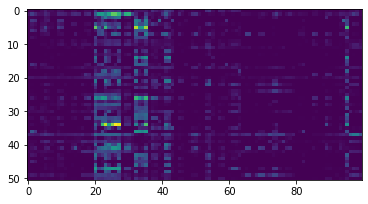

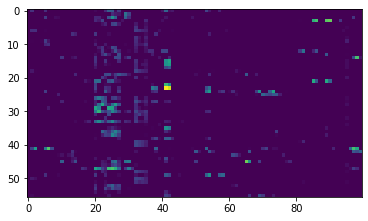

In [12]:
plt.figure()
plt.imshow(clf.feature_count_[:,:100])
plt.figure()
plt.imshow(X_train[::310,:100])

In [33]:
from sklearn.utils import shuffle

clf = GaussianNB()
X,y = shuffle(X_train, y_train)
clf.fit(X,y)
y_pred_test=clf.predict(X_test.cpu())
acc = accuracy_score(y_test, y_pred_test)
print(acc)

0.5704794916233391


In [ ]:
from sklearn_genetic.plots import plot_fitness_evolution
plt.figure()
plot_fitness_evolution(evolved_estimator)
plt.show()

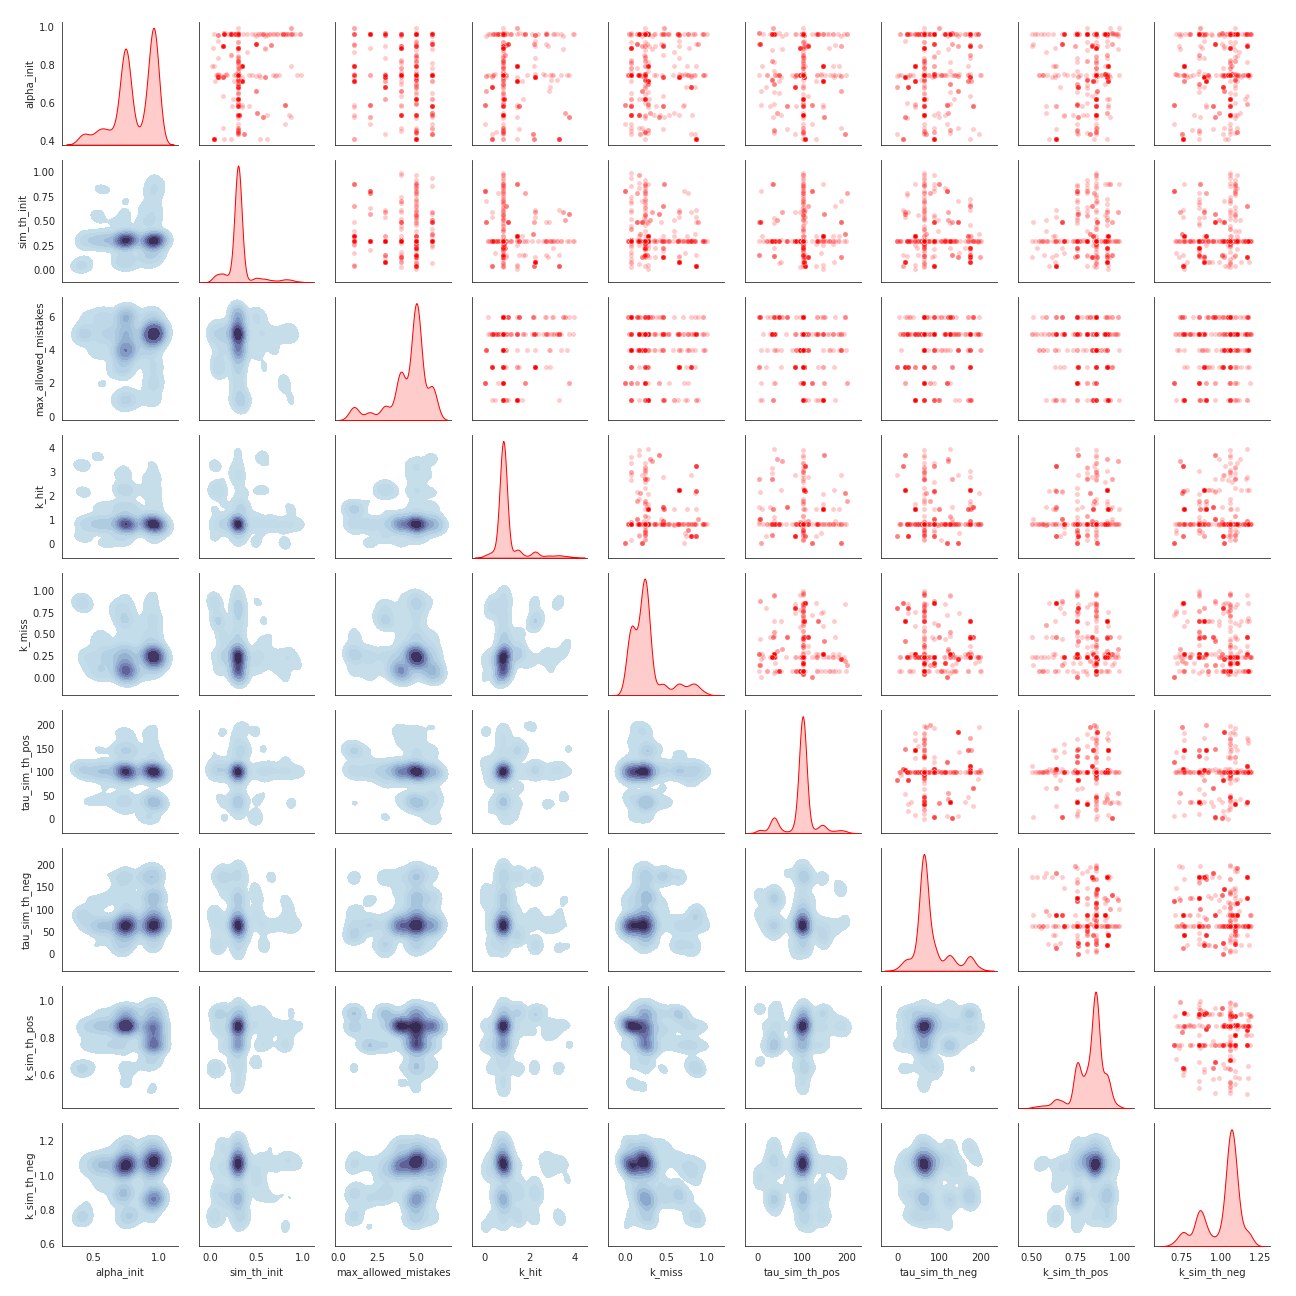

In [17]:
from sklearn_genetic.plots import plot_search_space
plot_search_space(evolved_estimator, features=['alpha_init', 'sim_th_init', 'max_allowed_mistakes','k_hit', 'k_miss',
                                               'tau_sim_th_pos', 'tau_sim_th_neg', 'k_sim_th_pos','k_sim_th_neg'])
plt.show()

In [3]:
from avalanche.training.plugins import SupervisedPlugin
from avalanche.training.templates.supervised import SupervisedTemplate
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.models.dynamic_modules import MultiTaskModule
from avalanche.models import FeatureExtractorBackbone
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    loss_metrics,
    forgetting_metrics,
    confusion_matrix_metrics,
)
from avalanche.training.supervised.deep_slda import StreamingLDA
from avalanche.models import SLDAResNetModel
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

n_classes = len(np.unique(train_ds.targets))


nc_bm = nc_benchmark(train_ds, test_ds, 
                     n_experiences=n_classes, 
                     shuffle=False,task_labels=False)


device = "cuda" if torch.cuda.is_available() else "cpu"

model = torchvision.models.vgg16(weights='IMAGENET1K_V1')

model = nn.Sequential(*list(model.children())[:1], nn.Flatten() )
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
model_name = 'vgg'
batch_size = 50
shrinkage = 1e-4
plastic_cov = True
feature_size = 512*4*4


# log_dir = "logs/wrgbd/" +  "slda_" + model_name + "__" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# log_dir = "logs/coil_100_clean/" + "clp_test_size=0.9__sim_th=-6__max_miss=4_euclidean" 

eval_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True),
        forgetting_metrics(experience=True, stream=True),
        confusion_matrix_metrics(num_classes=nc_bm.n_classes, save_image=False, stream=True),
        loggers=[],
        benchmark=nc_bm
)

# CREATE THE STRATEGY INSTANCEi

criterion = torch.nn.CrossEntropyLoss()

slda = StreamingLDA(
    model,
    criterion,
    feature_size,
    n_classes,
    eval_mb_size=batch_size,
    train_mb_size=batch_size,
    train_epochs=1,
    shrinkage_param=shrinkage,
    streaming_update_sigma=plastic_cov,
    device=device,
    evaluator=eval_plugin,
)

# TRAINING LOOP
n_loops = 1
n_cls_per_task = 51

cum_accs = []
print("Starting experiment...")
for loop in range(1,n_loops+1):
    for i, exp in enumerate(nc_bm.train_stream):

        # fit SLDA model to batch (one sample at a time)
        slda.train(exp)
        if (i+1)%n_cls_per_task == 0:
            # evaluate model on test data
            results = slda.eval(nc_bm.test_stream[:min(loop*(i+1),n_classes)])
            acc = results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
            cum_accs.append(acc)
            print("After learning ",str(i+1), " classes")
            print("Cumulative accuracy so far: ", str(acc))
            print("---------------------------------------------------------------------")

acc = results['Top1_Acc_Stream/eval_phase/test_stream/Task000']


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/avalanche/training/plugins/evaluation.py:92: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Starting experiment...
After learning  51  classes
Cumulative accuracy so far:  0.7231260894828588
---------------------------------------------------------------------


In [5]:
acc

0.7231260894828588